# Index

1. Generation of synthetic biological data, [Theory](#theory)
    1. [References](#refs)
2. Generation of synthetic biological data, [Implementation](#implementation)
    1. [Generating the PSDRs](#gen_psdrs) $a_c(\sigma)$
        1. [Generating the SDRs](#gen_sdrs) $s_c(t)$
        2. [Test SDR generation](#test_sdrs) by plotting three examples
        3. Converting the [SDRs to PSDRs](#sdrs2psdrs)
            1. Converting the SDRs to an intermidate function $v_c(\tau)$
            2. [Test generation of intermediate functions](#test_vs) by plotting three examples.
            3. Converting the intermediate functions to PSDRs
        4. [Test PSDR generation](#test_psdrs) by plotting three examples
        5. [Generating PSDRs for an example](#gen_example_psdrs) case with a realistic number of cells
    2. [Generating the synthetic images](#gen_ims)
        1. [Kernel computation](#kers)
        2. Code for the computation of final images (using TensorFlow)
        3. [Test image generation](#test_fluorospot) by plotting one
        4. [Generation of test data-base](#gen_testDB)
        5. [Generation of training data-base](#gen_trainDB)


<a id="theory"></a>
# Generation of synthetic biological data, Theory

In this section, we will generate synthetic Fluorospot [\[3\]][3] data from an arbitrary number of cells using the methodology suggested in [\[1\]][1]. The source density rate (SDR) $s_c(t)$ of a cell $c$ at time $t$ is defined as the concentration of particles secreted by the cell in an instant of the experiment. Here, we will make reasonable assumptions on the SDR of each cell $c\in\lbrace1,2,\dots,C\rbrace$ to reproduce the simulation conditions used for numerical results in [\[2\]][2].

From the SDR for each cell, we will obtain the post adsorption-desorption source density rate (PSDR), 
$$
a_c(\sigma) = \frac{\sigma}{D} v_c\!\left(\frac{\sigma^2}{2D}, T \right),
$$
where $v_c(\tau,T) = \int_{\tau}^T s_c(T-\eta) \varphi(\tau,\eta) \mathrm{d}\eta$ is explained below.
The benefit of obtaning the PSDR is that the observed image depends linearly on a sparse 3D function containing the PSDR  for each cell (more on this later). Here, $\varphi(\cdot,\cdot)$ has no relation whatsoever with the non-linear functions discussed in the implementation of the `SpotNet` and `ConvNet`, and is instead defined by the infinite sum 
$$
\varphi(\tau,t) = i_{[0,t)}(\tau) \sum_{j=1}^\infty \phi^{j*}(\tau) p\left[j-1;\kappa_{\mathrm{d}}(t-\tau)\right]\,,
$$ 
where $p[j;\lambda]$ is the probability mass function of a Poisson random variable with some mean $\lambda\geq0$ evaluated at $j\in\mathbb{N}$ [\[4\]][4],
$$
\phi^{j*}(\tau) = (\underbrace{\phi * \phi *\dots* \phi}_{j})(\tau)\,\,\mbox{  and  }\,\,\phi(\tau) =  \frac{\kappa_{\mathrm{a}}}{\sqrt{\pi D \tau}}- \frac{\kappa_{\mathrm{a}}^2}{D} \mathrm{erfcx}\left( \kappa_{\mathrm{a}} \sqrt{\frac{\tau}{D}} \right)\,.
$$ 
See [\[5\]][5] for definitions of the complementary $\mathrm{erfc}(\cdot)$ and scaled-complementary $\mathrm{erfcx}(\cdot)$ error functions. Clearly, the infinite sum must be clipped for computation, every function must be discretized and represented by an array, and every integral must be approximated. For more detail and guarantees of approximability please refer to \[[1][1],[2][2]\], their supplementary material, and the implementation below.

After generating the $a_c(\sigma)$ for each cell and randomly deciding its position $(x_c,y_c)$ as a discrete uniform pixel-centered location, we will build a 3D function $a(x,y,\sigma)$, the global PSDR. This PSDR is such that $a(x_c,y_c,\sigma) = a_c(\sigma)$ for every $c$ and $a(x,y,\sigma)=0$ for any other location $(x,y)$ and every $\sigma$, and will be represented here by a sparse 3D array. Then, we generate the image observation using that [\[1\]][1] 
$$
d_\mathrm{obs}(x,y) = \int_0^{\sigma_{\mathrm{max}}} g_{\sigma}(x,y) * \, a(x,y,\sigma) \mathrm{d}\sigma\,,
$$
where $g_\sigma(x,y)$ is a 2D separable Gaussian kernel corresponding to a Gaussian probability density function with standard deviation $\sigma$.

<a id="refs"></a>
## References
[1]: https://arxiv.org/abs/1710.01604
[2]: https://arxiv.org/abs/1710.01622
[3]: https://en.wikipedia.org/wiki/FluoroSpot
[4]: https://en.wikipedia.org/wiki/Poisson_distribution
[5]: https://en.wikipedia.org/wiki/Error_function#Complementary_error_function
[6]: https://doi.org/10.1080/03610918008812164

[\[1\]][1]: Pol del Aguila Pla and Joakim Jaldén, "Cell Detection by Functional Inverse Diffusion and Group Sparsity − Part I: Modeling and Inverse Problems", _IEEE Transactions on Signal Processing_, vol. 66, no. 20, pp. 5407--5421, 2018  
[\[2\]][2]: Pol del Aguila Pla and Joakim Jaldén, "Cell Detection by Functional Inverse Diffusion and Group Sparsity − Part II: Proximal Optimization and Performance Evaluation", _IEEE Transactions on Signal Processing_, vol. 66, no. 20, pp. 5422--5437, 2018  
[\[3\]][3]: "FluoroSpot", _Wikipedia, the free encyclopedia_   
[\[4\]][4]: "Poisson distribution", _Wikipedia, the free encyclopedia_    
[\[5\]][5]: "Error function, Derived and related functions, Complementary error function", _Wikipedia, the free encyclopedia_   
[\[6\]][6]: D. B. Owen, "A table of normal integrals", _Communications in Statistics - Simulation and Computation_, pp. 389--419, 1980

<a id="implementation"></a>
# Generation of synthetic biological data, Implementation

In [1]:
import numpy as np
from scipy import integrate,special,linalg
from scipy.stats import norm

<a id="gen_psdrs"></a>
## Generating the PSDRs $a_c(\sigma)$
<a id="gen_sdrs"></a>
### Generating the SDRs $s_c(t)$

Generate all the SDRs $s_c(t)$ for $c\in\lbrace1,\dots,$ `nrof_cells` $\rbrace$ in an experiment of `seconds_experiment_length` seconds, discretizing them with `nrof_time_points`. Each SDR is generated as a square pulse with start and end points randomly drawn within the discretization points between `earliest_start` and `latest_end`. In order to limit the difficulty of the final inverse problem, we do not allow the total secretion between any two cells to vary beyond a factor of `smallest_ratio`. 

The $s_c(t)$s are returned as a tuple $(s,t)$, in which $s$ is `nrof_cells` $\times$ `nrof_time_points` and $t$ is a $1$-dimensional array with `nrof_time_points+1` elements, representing the borders of the intervals in which each column in $s$ is valid.

In [2]:
def get_SDRs( nrof_cells = 750,
              nrof_time_points = 1000,
              seconds_experiment_length = 8*3600,
              earliest_start = 1*3600,
              latest_end = 6*3600,
              smallest_ratio = 0.5 ):
    
    # Get integers for start and end points for each SDR and ensure they are not the same
    while True:
        # Generate random integer times and sort to make sure start time > end time
        start_and_end_times = np.sort( 
                                  np.random.randint( 
                                      low  = int(((nrof_time_points-1) * earliest_start) / seconds_experiment_length),
                                      high = int(((nrof_time_points-1) * latest_end ) /seconds_experiment_length), 
                                      size = (nrof_cells, 2)),
                              axis = 1 )
        
        # Check that the start and end times for a cell are not the same
        if ~np.any( start_and_end_times[:,0] == start_and_end_times[:,1] ):
            break
    
    # Fill the SDRs between start and end with a constant random value corresponding to total secretion between
    # a maximum (arbitrarily fixed to nrof_time_points) and the value given by the smallest considered ratio
    sdrs = np.zeros( (nrof_cells, nrof_time_points) )
    for idx, _ in enumerate( sdrs ):
        secretion_start_time = start_and_end_times[idx,0]
        secretion_end_time = start_and_end_times[idx,1]
        
        sdrs[idx, secretion_start_time : secretion_end_time + 1] = ( 
            np.random.uniform( low = smallest_ratio * nrof_time_points, high = nrof_time_points ) / (
            secretion_end_time - secretion_start_time ) )
    
    # Compute limits of each of the intervals of the step function
    t_limits = np.arange( nrof_time_points + 1 ) * seconds_experiment_length / nrof_time_points
    
    return ( sdrs, t_limits )

<a id="test_sdrs"></a>
### Test SDR generation by plotting three examples.

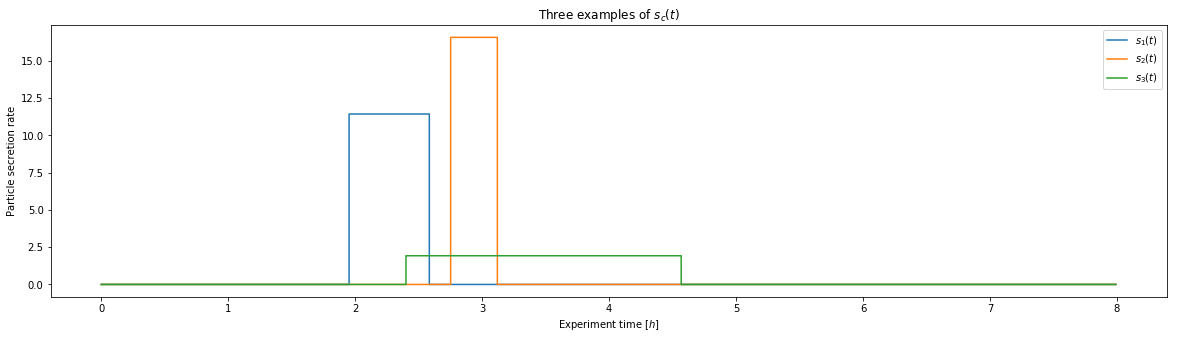

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(8814)
sdrs, t_lims = get_SDRs( nrof_cells = 3 )

plt.figure( figsize = ( 20, 5 ) )
plt.step( t_lims[:-1]/3600, sdrs[0,:], t_lims[:-1]/3600, sdrs[1,:], t_lims[:-1]/3600, sdrs[2,:], where = 'post' ); plt.title( r"Three examples of $s_c(t)$" ); plt.xlabel( r"Experiment time $[h]$" ); plt.ylabel( r"Particle secretion rate" ); plt.legend([r"$s_1(t)$",r"$s_2(t)$",r"$s_3(t)$"])

### Converting the SDRs $s_c(t)$ to PSDRs $a_c(\sigma)$
<a id="sdrs2psdrs"></a>

The objective of the section that follows is convert some SDRs $s_c(t)$ into the PSDRs $a_c(t)$. This part is complicated due to the need to discretize and approximate the infinite sums and integrals involved in the equation
$$
v_c(\tau,T) = \sum_{j=1}^\infty \phi^{j*}(\tau)\int_{\tau}^T s_c(T-\eta)   \left(p\left[j-1;\kappa_{\mathrm{d}}(\eta-\tau)\right]i_{[0,\eta)}(\tau)\right) \mathrm{d}\eta
$$
(see expressions above, as well as [\[1\]][1] and [\[2\]][2], for details). Indeed, the details of the representation of the $s_c(t)$s as step-constant functions become important to represent objects such as $v_c(\tau,T)$ or $a_c(\sigma)$. 

This task will be divided in two parts. First, in the function `transform_SDRs_to_Vs`, we will obtain an approximation for each $v_c(\tau,T)$ as given by the expression above, using some underlying assumptions and approximations. Then, in the function `transform_Vs_to_PSDRs`, we will obtain an approximation of each $a_c(\sigma)$.

#### Converting the SDRs $s_c(t)$ to $v_c(\tau,T)$s

Important notes to understand the implementation of `transform_SDRs_to_Vs` below are:
1. the computation of the discretization of $\phi^{j*}(\tau)$ is done by discretizing (integrating small pieces) the basic $\phi(\tau)$ (part manually, part numerically) and then using recurrent convolutions for the next convolutional products,
2. the function $\varphi(\tau,\eta)$ is not computed explicitly at any time. Instead, each of the summands that conform it, i.e., $\varphi_j(\tau,\eta) = \phi^{j*}(\tau) p\left[j-1;\kappa_{\mathrm{d}}(t-\tau)\right] i_{[0,t)}(\tau)$ is used individually, and the contributions of each of them to $v_c(\tau,T)$ are added up at each step.

[1]: https://arxiv.org/abs/1710.01604
[2]: https://arxiv.org/abs/1710.01622

In [5]:
def transform_SDRs_to_Vs( sdrs, 
                          t_limits,
                          diffusion_constant = 3e-12,
                          adsorption_constant = 6e-9,
                          desorption_constant = 1e-4,
                          nrof_rebinding_events_truncate = 20,
                          provide_varphi = False ):
    
    # Enforce input shape (vertical vectors for time component)
    t_limits = np.reshape( t_limits, (t_limits.size, 1) )
    
    # Extract implicit inputs
    nrof_cells, nrof_time_points = sdrs.shape
    t_centers = 0.5 * (t_limits[:-1] + t_limits[1:])
    
    ## Compute discretization of $\phi(\tau)$
    # Compute discretization of $\phi(\tau)$, analytical part
    phi_ini = ( 2 * adsorption_constant * (np.sqrt( t_limits[1:] ) - np.sqrt( t_limits[:-1] )) /
            np.sqrt( np.pi * diffusion_constant ) )
    # Compute discretization of $\phi(\tau)$, numerical part
    erfcx_term = lambda tau: (adsorption_constant ** 2 / diffusion_constant) * (
                special.erfcx( adsorption_constant * np.sqrt( tau / diffusion_constant ) ))
    for idx, _ in enumerate( phi_ini ):
        phi_ini[idx] -= integrate.quad( erfcx_term, t_limits[idx], t_limits[idx + 1] )[0] 
    
    ## Prepare for recursive computation of v (and optionally, \varphi)
    # Invert time in SDRs to prepare approximation of temporal integral
    sdrs = np.fliplr( sdrs );
    
    # Initialize output variables (obtained by accumulation of terms)
    
    # Output variable, containing all the $v_c(\tau,T)$s
    vs = np.zeros( (nrof_cells, nrof_time_points) )
    # Intermediate variable (not needed), $\varphi(\tau,t)$
    if provide_varphi:
        varphi = np.zeros( nrof_time_points, nrof_time_points )
    
    # Helping function for Poisson PMFs
    poisson_pmf = lambda val, lam: np.exp( -lam ) * (lam ** val) / special.factorial( val )
    
    ## Recursively approximate v
    for rebind in range( nrof_rebinding_events_truncate ):
        
        if rebind == 0:
            # For a single rebind, load discretized $\phi(\tau)$
            phi_rebind = phi_ini
        else:
            # For the subsequent rebinds, perform discretized convolution to approximate $\phi^j(\tau)$
            phi_rebind = np.expand_dims( np.convolve( phi_rebind[:,0], phi_ini[:,0] ), 1 )
            
            # Clip for only the smallest times in free motion (indicator in formulas).
            # Note that doing this does not interfere with the computation of the 0:nrof_time_points section of higher
            # convolutional powers, and avoids unnecessary computations
            phi_rebind = phi_rebind[:nrof_time_points]
        
        # Array representing the different values taken by the Poisson distribution
        # expression when one changes \tau and \eta, dim 0 is \tau and dim 1 is \eta
        poisson_with_indicator_rebind = linalg.triu( linalg.toeplitz( 
                poisson_pmf( rebind, 
                            desorption_constant * np.reshape( t_centers, (1, t_centers.size) ) 
                           ) ) )  
        
        # Update on $\varphi(\tau,t)$
        if provide_varphi:
            varphi += phi_rebind * poisson_with_indicator_rebind
        
        # Update on each of the $v_c(\tau,T)$
        vs += ( np.sum( 
                 np.expand_dims( sdrs, 2 ) * 
                 np.expand_dims( poisson_with_indicator_rebind.swapaxes( 0, 1 ), 0 )    
               , 1, keepdims = True ) *  np.expand_dims( phi_rebind.swapaxes( 0, 1 ), 0 ) 
             ).swapaxes( 1, 2 ).squeeze( axis = 2 )
    
    if provide_varphi:
        return ( vs, varphi )
    return vs

<a id="test_vs"></a>
#### Test generation of $v_c(\tau)$s by plotting three examples. 
1) Transform SDRs for three cells in Vs, 
2) Plot result (sdrs,t_lims) = get_SDRs( nrof_cells = 3 ) 

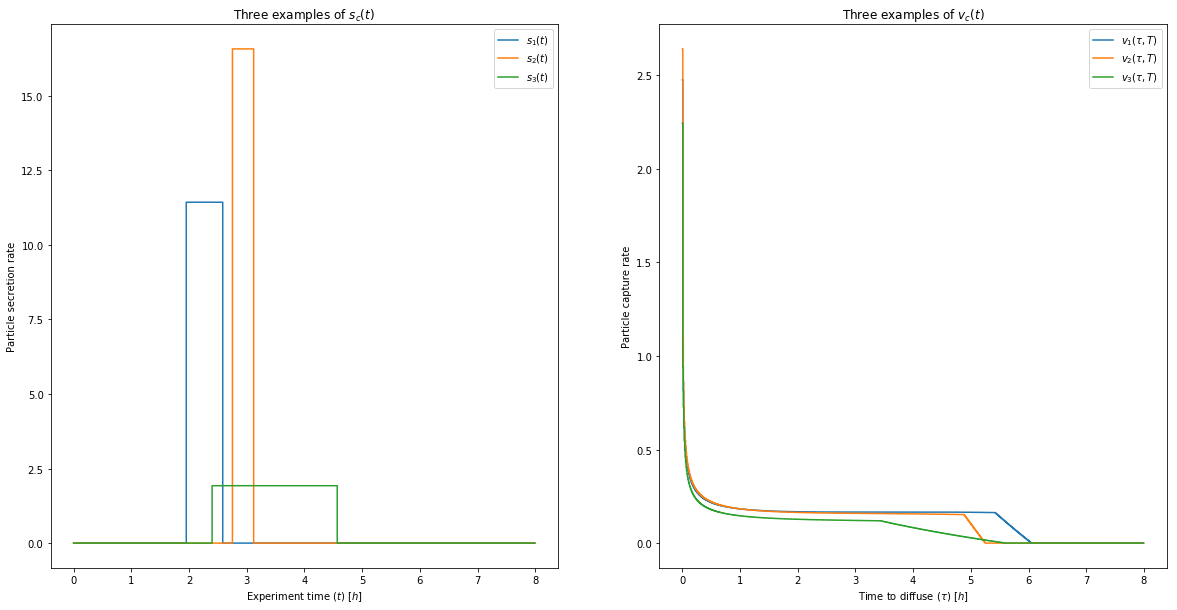

In [6]:
vs = transform_SDRs_to_Vs( sdrs, t_lims )

plt.figure( figsize = ( 20, 10 ) )
plt.subplot(121); plt.step( t_lims[:-1]/3600, sdrs[0,:], t_lims[:-1]/3600, sdrs[1,:], t_lims[:-1]/3600, sdrs[2,:], where = 'post' ); plt.title( r"Three examples of $s_c(t)$" ); plt.xlabel( r"Experiment time ($t$) $[h]$" ); plt.ylabel( r"Particle secretion rate" ); plt.legend([r"$s_1(t)$",r"$s_2(t)$",r"$s_3(t)$"]);
plt.subplot(122); plt.step( t_lims[:-1]/3600, vs[0,:], t_lims[:-1]/3600, vs[1,:], t_lims[:-1]/3600, vs[2,:], where = 'post' );          plt.title( r"Three examples of $v_c(t)$" ); plt.xlabel( r"Time to diffuse ($\tau$) $[h]$" ); plt.ylabel( r"Particle capture rate" ); plt.legend([r"$v_1(\tau,T)$",r"$v_2(\tau,T)$",r"$v_3(\tau,T)$"]);

#### Converting the $v_c(\tau,T)$s to PSDRs

The interested reader should take into account that
1. the chosen strategy to implement this and still obtain an approximately uniform discretization in $\sigma$, which would not be the case if we did it naively ( because the time discretization is uniform, and $\sigma=\sqrt{2D\tau}$ ), is to  
  1.1. not use the conversion $a_c(\sigma) = \frac{\sigma}{D} v_c\!\left(\frac{\sigma^2}{2D}, T \right)$ between continuous densities, but approximate instead the value of $a_{c,k}=\int_{\tau_{k-1}}^{\tau_k} v_c\!(\tau,T)$ for some $\tau_{k-1}<\tau_{k}$ corresponding to some desired boundaries $\sigma_{k-1}<\sigma_k$. Consequently, the number of points in the discretization of $\tau$ or $t$ and the discretization of $\sigma$ will be different.  
  1.2. approximate $a_c(\sigma)$ in that area as step-constant function that yields that mass, i.e., $a_c(\sigma)\approx \frac{a_{c,k}}{\sigma_{k}-\sigma_{k-1}}$ for $\sigma\in[\sigma_{k-1},\sigma_k)$.
2. the $\sigma$s refered here are the $\tilde{\sigma}$s of [\[2\]][2], i.e., they're normalized to units of pixels.

Finally, consider that, as explained in [\[1\]][1] and its supplementary material, the representation of $a(\sigma)$ used throughout [\[1\]][1] and [\[2\]][2] is such that each $a_c$ is represented by $K$ values $\tilde{a}_{c,k}$ such that
$$\tilde{a}_{c,k}=\frac{1}{\sqrt{\sigma_k-\sigma_{k-1}}} \int_{\sigma_{k-1}}^{\sigma_k} a_c(\sigma) \mathrm{d}\sigma = \frac{1}{\sqrt{\sigma_k-\sigma_{k-1}}}
\int_{\sigma_{k-1}}^{\sigma_k} \frac{a_{c,k}}{\sigma_{k}-\sigma_{k-1}}\mathrm{d}\sigma = \frac{a_{c,k}}{\sqrt{\sigma_k-\sigma_{k-1}}}\,.$$
Thereby, in the code below there will be a flag `representation_as_papers` which will default to `True` to output $\tilde{a}_{c,k}$s, but that, if set to `False`, will make the function output the $a_{c,k}$s, which are more convenient for plotting and for comparison with previous implementations.

[1]: https://arxiv.org/abs/1710.01604
[2]: https://arxiv.org/abs/1710.01622


In [8]:
def transform_Vs_to_PSDRs( vs, 
                           t_limits, 
                           nrof_sigma_centers = 30, 
                           diffusion_constant = 3e-12, 
                           pixel_length = 6.45e-6,
                           representation_as_papers = True ):
    
    # Compute existing boundaries in the \sigma domain
    time_limits_to_sigma = np.sqrt( 2 * diffusion_constant * t_limits ) / pixel_length
    
    ## Generate ideal grid
    # If the user requirement is impossible (we don't have enough resolution)
    if time_limits_to_sigma[1] > time_limits_to_sigma[-1] / nrof_sigma_centers:
        # Compute grid with the most points (for geeks,sqrt is expansive at the 
        # beginning and compressive at the end)
        sigma_limits_ideal = np.arange( time_limits_to_sigma[0 ], 
                                        time_limits_to_sigma[-1],
                                        time_limits_to_sigma[1 ] )
        sigma_limits_ideal = np.append( sigma_limits_ideal, time_limits_to_sigma[-1] )
        # Issue warning (TODO: Change to proper warning)
        print( "nrof_sigma_points unfeasible, " + str( sigma_limits_ideal.size ) + 
               " points used instead" )
    else:
        sigma_limits_ideal = np.linspace( time_limits_to_sigma[0 ], 
                                          time_limits_to_sigma[-1],
                                          num = nrof_sigma_centers + 1 )
    
    ## Find closest possible approximation
    # Compute distance (broadcasting)
    distance_matrix = np.absolute( np.expand_dims( sigma_limits_ideal, axis = 1 )
                                   - np.reshape( time_limits_to_sigma, ( 1, time_limits_to_sigma.size ) ) )
    
    # Find minimum distance element in existing limits for each ideal \sigma limit
    # and build real \sigma limits array
    sigma_limits_indices = np.argmin( distance_matrix, axis = 1 )
    sigma_limits_real = time_limits_to_sigma[sigma_limits_indices]
    
    ## Create PSDRs 
    # Initialize. Note: (sigma_limits_real.size - 1 should be nrof_sigma_centers in normal cases)
    psdrs = np.empty( ( vs.shape[0], sigma_limits_real.size - 1 ) )
    for idx in range( sigma_limits_real.size - 1 ):
        # Integrate over intervals and divide by length
        psdrs[:, idx] = np.sum( vs[:, sigma_limits_indices[idx] : sigma_limits_indices[idx+1]], axis = 1 )
        
        if representation_as_papers:
            psdrs[:, idx] = psdrs[:, idx] / np.sqrt( sigma_limits_real[idx+1] - sigma_limits_real[idx] )
        else:
            psdrs[:, idx] = psdrs[:, idx] / ( sigma_limits_real[idx+1] - sigma_limits_real[idx] ) 
    
    return ( psdrs, sigma_limits_real )

<a id="test_psdrs"></a>
### Test PSDRs by plotting three examples. 
1) Transform SDRs for three cells in Vs, 
2) Plot result

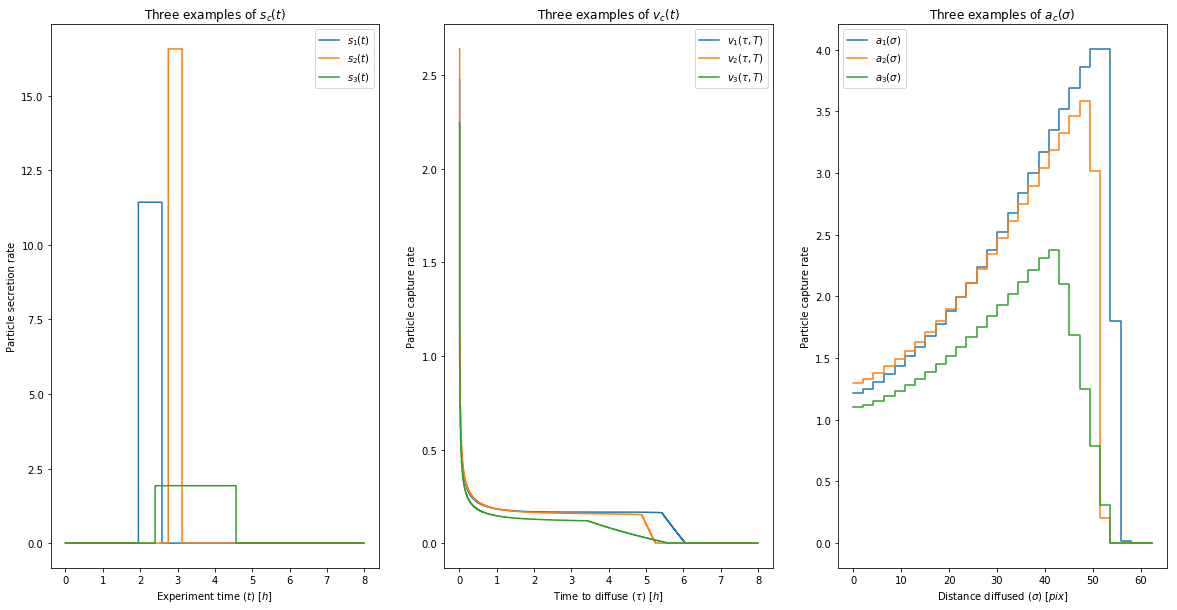

In [9]:
# sdrs, t_lims = get_SDRs( nrof_cells = 3 ) # Uncomment if the test of get_SDRs has not been run
# vs = transform_SDRs_to_Vs( sdrs, t_lims ) # Uncomment if the test of transform_SDRs_to_Vs has not been run

psdrs, sigma_lims = transform_Vs_to_PSDRs( vs, t_lims, representation_as_papers = False )

plt.figure( figsize = ( 20, 10 ) )
plt.subplot(131); plt.step( t_lims[:-1]/3600, sdrs[0,:], t_lims[:-1]/3600, sdrs[1,:], t_lims[:-1]/3600, sdrs[2,:], where = 'post' ); plt.title( r"Three examples of $s_c(t)$" ); plt.xlabel( r"Experiment time ($t$) $[h]$" ); plt.ylabel( r"Particle secretion rate" ); plt.legend([r"$s_1(t)$",r"$s_2(t)$",r"$s_3(t)$"]);
plt.subplot(132); plt.step( t_lims[:-1]/3600, vs[0,:], t_lims[:-1]/3600, vs[1,:], t_lims[:-1]/3600, vs[2,:], where = 'post' ); plt.title( r"Three examples of $v_c(t)$" ); plt.xlabel( r"Time to diffuse ($\tau$) $[h]$" ); plt.ylabel( r"Particle capture rate" ); plt.legend([r"$v_1(\tau,T)$",r"$v_2(\tau,T)$",r"$v_3(\tau,T)$"]);
plt.subplot(133); plt.step( sigma_lims[:-1], psdrs[0,:], sigma_lims[:-1], psdrs[1,:], sigma_lims[:-1], psdrs[2,:], where = 'post' ); plt.title( r"Three examples of $a_c(\sigma)$" ); plt.xlabel( r"Distance diffused ($\sigma$) $[pix]$" ); plt.ylabel( r"Particle capture rate" ); plt.legend([r"$a_1(\sigma)$",r"$a_2(\sigma)$",r"$a_3(\sigma)$"]);

Note that these results have been verified to match those obtained by the MATLAB implementation used in [\[1\]][1] and [\[2\]][2].

[1]: https://arxiv.org/abs/1710.01604
[2]: https://arxiv.org/abs/1710.01622

<a id="gen_example_psdrs"></a>
### Generate example data and visualize its cuts

In [11]:
def generate_experiment( nrof_cells = 750, nrof_pixels = 512, seed = 42):
    np.random.seed(seed)
    
    sdrs, t_lims = get_SDRs( nrof_cells = nrof_cells )
    vs = transform_SDRs_to_Vs( sdrs, t_lims )
    psdrs, sigma_lims = transform_Vs_to_PSDRs( vs, t_lims )
    space_and_time_description = np.empty( [nrof_pixels, nrof_pixels, sigma_lims.size - 1]  )
    for index in range( sdrs.shape[0] ):
        m_and_n = np.random.randint( low = 0, high = 512, size = 2 )
        space_and_time_description[m_and_n[0], m_and_n[1], :] = psdrs[index, :]
        
    return (space_and_time_description, sigma_lims)

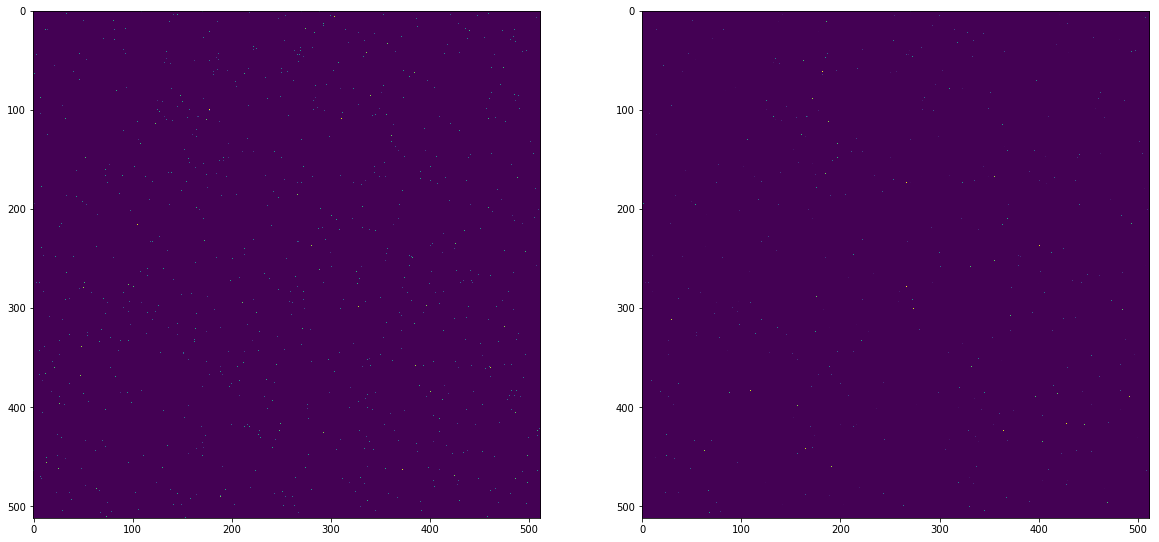

In [12]:
nrof_cells = 750
a_experiment, sigma_lims = generate_experiment( nrof_cells = nrof_cells, seed = 99 )

plt.figure( figsize = ( 20, 10 ) );
plt.subplot( 121 ); plt.imshow( a_experiment[:, :, 0]   ); 
plt.subplot( 122 ); plt.imshow( a_experiment[:, :, 25] );

<a id="gen_ims"></a>
## Generating the synthetic images
<a id="kers"></a>
### Kernel computation

As detailed in the beginning of this notebook, if we arrange a 3D function $a(x,y,\sigma)$ such that $a(x_c,y_c,\sigma) = a_c(\sigma)$ for every $c$ and $a(x,y,\sigma)=0$ for any other location $(x,y)$, then the observed image can be expressed
$$d_\mathrm{obs}(x,y) = \int_0^{\sigma_{\mathrm{max}}} g_{\sigma}(x,y) * \, a(x,y,\sigma) \mathrm{d}\sigma\,.$$

Given the discrete representation of each $a_c(\sigma)$ we obtained above, a discrete representation $\tilde{d}_\mathrm{obs}$ of $d_\mathrm{obs}(x,y)$ can be obtained as
$$
    \tilde{d}_\mathrm{obs} = \sum_{k=1}^K \tilde{g}_k \circledast \tilde{a}_k\,.
$$
Here, the convolutional kernels $\tilde{g}_k$ are formed by definite integrations over spatial variables and scale parameters of one-dimensional Gaussian functions such that 
$$
    \tilde{g}_k[(m,n)] =
    \frac{1}{\sqrt{\sigma_k - \sigma_{k-1}}}
    \int_{\sigma_{k-1}}^{\sigma_k}
    \omega_\sigma(m) \omega_\sigma(n) \mathrm{d}\sigma
$$
with 
$$
    \omega_\sigma(m) = \int_{-\frac{1}{2}}^{\frac{1}{2}}
    \left[ \Phi\left(\frac{m+\rho+\frac{1}{2}}{\sigma}\right) -
    \Phi\left(\frac{m+\rho-\frac{1}{2}}{\sigma}\right)\right]
    \mathrm{d}\rho\,,
$$
and $\Phi(\cdot)$ being the cumulative density function of the standard Gaussian distribution.
While the computation of this second expression can be done in closed form using very specific results [\[6\]][6] (see the supplementary material of \[[1][1], [2][2]\] for details), the integral over $\sigma$ has to be done numerically

[1]: https://arxiv.org/abs/1710.01604
[2]: https://arxiv.org/abs/1710.01622
[6]: https://doi.org/10.1080/03610918008812164


In [13]:
# Compute $\omega_\sigma(m)$ for a range of $m$s
def doubly_spatially_integrated_Gaussian_one_dim( sigma, support ):
    # Use expression (Owen, 1980) to resolve double spatial integration over Gaussian
    normal_zero_sigma = norm( loc = 0, scale = sigma ) 
    return (
      (support + 1) * normal_zero_sigma.cdf( support + 1 )+
      (support - 1) * normal_zero_sigma.cdf( support - 1 )
    - (2 * support) * normal_zero_sigma.cdf( support     )
    + sigma**2 * (
                      normal_zero_sigma.pdf( support + 1 )+
                      normal_zero_sigma.pdf( support - 1 )
    - 2 *             normal_zero_sigma.pdf( support     )
     ) )

# Compute $\omega_\sigma(m)*\omega_\sigma(n)$ for a range of $m$s, $n$s and $\sigma$s
def stacked_doubly_spatially_integrated_Gaussian( sigmas, support ):
    # Initialize output, number of $m$s by number of $n$s by number of $\sigma$s
    stacked_output = np.empty( (support.size, support.size, sigmas.size) )
    for index in range( sigmas.size ):
        # Get one-dimensional for range
        auxiliar = doubly_spatially_integrated_Gaussian_one_dim( sigmas[index], support )
        # Outer product of two-dimensional in range x range
        stacked_output[...,index] = np.transpose( auxiliar )*auxiliar
    return stacked_output

# Once spatially integrated Gaussian, for simulating optical blur
def spatially_integrated_Gaussian( sigma = 2.279 ):
    support = np.array( [np.arange( -np.ceil( 3*sigma ), np.ceil( 3*sigma )+1, 1 )]  )
    normal_zero_sigma = norm( loc = 0, scale = sigma )
    auxiliar = ( normal_zero_sigma.cdf( support + .5 ) 
                    - normal_zero_sigma.cdf( support  -  .5 ) )
    return auxiliar * np.transpose( auxiliar )    

In [14]:
def obtain_discrete_kernels( sigma_limits ):
    # (!!) Extreme inefficiency, all filters are the same size, the maximum one (!!) See figure for smallest kernel below
    # Compute support for maximum sigma
    support = np.array( [np.arange( -np.ceil( 3 * sigma_limits[-1] ), np.ceil( 3 * sigma_limits[-1] ) + 1, 1 )] )
    
    # Initialize array
    kernels = np.empty( (support.size, support.size, sigma_limits.size - 1) )
    for index in range( sigma_limits.size-1 ):
        # Compute integral over \sigma
        kernels[...,index] = integrate.fixed_quad( stacked_doubly_spatially_integrated_Gaussian,
                                                   sigma_limits[index], sigma_limits[index + 1],
                                                   args = (support,) )[0]
        
        kernels[...,index] = kernels[...,index] / np.sqrt( sigma_limits[index + 1] - sigma_limits[index] )
        
    return kernels

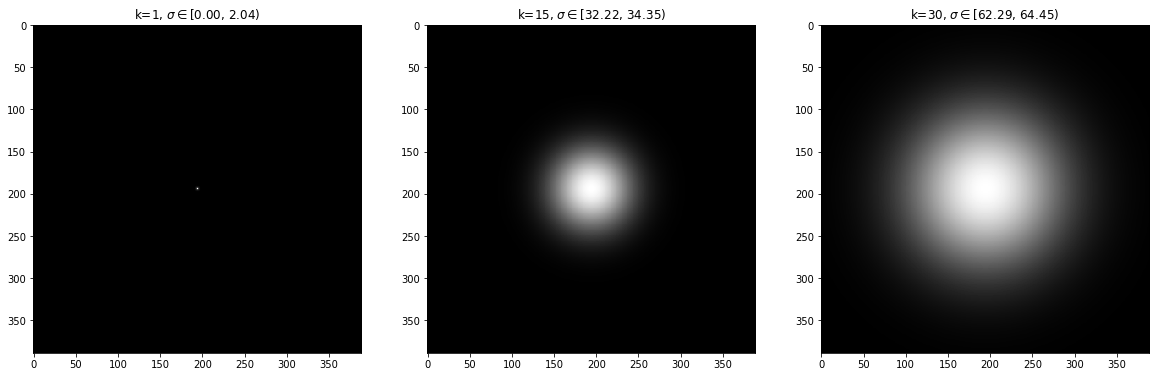

In [16]:
kers = obtain_discrete_kernels( sigma_lims )

plt.figure( figsize = ( 20, 10 ) ); s = lambda x: "{0:.2f}".format( x ); mid = int(np.round( sigma_lims.size/2-.5 ))
plt.subplot( 131 ); plt.imshow( kers[:,:,0]  ); plt.title( "k=" + str( 1 )   + r", $\sigma \in [$" + s( sigma_lims[0]  ) + ", " + s( sigma_lims[1]  )     + r"$)$" ); plt.set_cmap('gray')
plt.subplot( 132 ); plt.imshow( kers[:,:, mid ] ); plt.title( "k=" + str( mid ) + r", $\sigma \in [$" + s( sigma_lims[mid] ) + ", " + s( sigma_lims[mid+1] ) + r"$)$" ); plt.set_cmap('gray')
plt.subplot( 133 ); plt.imshow( kers[:,:,-1] ); plt.title( "k=" + str( sigma_lims.size-1 ) + r", $\sigma \in [$" + s( sigma_lims[-2] ) + ", " + s( sigma_lims[-1] ) + r"$)$" ); plt.set_cmap('gray')

### Code for the computation of final images (using TensorFlow)

In [17]:
import tensorflow as tf

def get_image_creator( discrete_kernels,
                       optical_kernel = tf.constant( spatially_integrated_Gaussian( ), dtype = tf.float32 ),
                       dimension_image = 512, 
                       nrof_sigma_centers = 30,
                       quantization_bits_noise = 6):
    
    # Alternatively, load more than one by non-singleton first dimension (discuss with Vidit)
    space_and_time_description_placehoder = tf.placeholder( tf.float32, [ dimension_image,
                                                                          dimension_image, 
                                                                          nrof_sigma_centers ] )
    
    # Format NHWC
    space_and_time_description = tf.expand_dims( space_and_time_description_placehoder, axis=0 )
    
    with tf.name_scope( "forward_operator" ):
        # Format HWCM M: channel multiplier (1)
        discrete_kernels = tf.expand_dims( tf.constant( discrete_kernels, dtype = tf.float32 ), axis = 3 )
        # Convolve each layer
        conv = tf.nn.depthwise_conv2d( input = space_and_time_description,
                                       filter = discrete_kernels,
                                       strides = [1, 1, 1, 1],
                                       padding = 'SAME'  )
        
        # Add up
        image_pure = tf.expand_dims( tf.reduce_sum( conv, 3 ), axis= 3 )
        
    with tf.name_scope( "physical_flaws" ):
        # Make an optical blur
        image_without_noise = tf.nn.conv2d( image_pure,
                                            tf.expand_dims( tf.expand_dims( optical_kernel, axis = 2 ), axis = 3 ),
                                            strides = [1, 1, 1, 1],
                                            padding = 'SAME' )
        
        # Store normalization value and normalize to [0,1]
        normalization = 1 / tf.reduce_max( image_without_noise )
        image_without_noise = normalization * image_without_noise
        
        # Add noise and clip to [0,255]
        standard_deviation = np.sqrt( 2 ** (-2 * quantization_bits_noise) / 12 )
        image_final = tf.minimum( 255 * tf.maximum( image_without_noise
                          + tf.random_normal( image_without_noise.shape, mean = 0, stddev = standard_deviation ), 0 ), 255 )
        
    # Normalize input and return
    proportional_space_and_time_description = 255 * normalization * tf.squeeze( space_and_time_description, axis = 0 )

    return ( image_final, proportional_space_and_time_description, space_and_time_description_placehoder )

image, a, a_initial = get_image_creator( kers )

<a id="test_fluorospot"></a>
### Test of synthetic Fluorospot image generation

In [18]:
sess = tf.Session(  )
sess.run( tf.global_variables_initializer( ) )

image_output, a_output = sess.run( [image, a], feed_dict = { a_initial: a_experiment } )

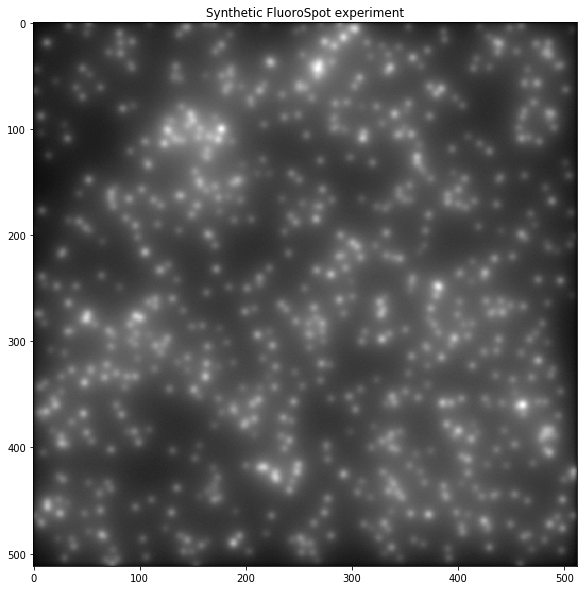

In [28]:
plt.figure( figsize = (12, 10) ) 
plt.imshow( image_output[0,:,:,0] )
plt.title( "Synthetic FluoroSpot experiment" );

<a id="gen_testDB"></a>
### Generate test data-base

In [21]:
sess = tf.Session(  )
sess.run( tf.global_variables_initializer( ) )

nrof_images = 50
nrof_cells_array = np.array( [250, 750, 1250] )
sim_dir = 'sim_data/'

for nrof_cells in nrof_cells_array: 
    
    # Define data storage shapes
    fluorospot = np.ndarray( ( nrof_images, 512, 512 ) )
    psdrs = np.ndarray( ( nrof_images, *a_output.shape ) )
    # Inform patient user
    print( 'Generating images with %d cells'%( nrof_cells ) ) # There was a silly typo, changed after running as it is only a print
    
    # Generate images
    for image_number in range(nrof_images):
        
        # Get uniquely identifying file name
        filename = sim_dir + 'result_' + str( nrof_cells ) + '_cells_'+ str( nrof_images ) + '_images' + '.npy'
        # Obtain PSDRs (seed uniquely)
        a_experiment, sigma_lims = generate_experiment( nrof_cells = nrof_cells, seed = nrof_cells + image_number )
        # Generate image
        result = sess.run( [image, a], feed_dict = { a_initial: a_experiment } )
        # Store image and PSDR in memory
        fluorospot[image_number, :, :] = result[0][0,:,:,0]
        psdrs[image_number, :, :, :]   = result[1]
        # Inform patient user
        if image_number == 0:
            print( 'Generated image: 0', end = ', ' )
        elif image_number == nrof_images-1:
            print( str( image_number ), end = '.\n' )
        else:
            print( str( image_number ), end = ', '  )
    
    # Save to disk
    result = {'nrof_cells': nrof_cells,
              'fluorospot': fluorospot,
              'psdrs': psdrs}
    np.save( filename, result )
    print( 'Saved results to %s'%( filename ) )  

Generating images with 50 cells
Generated image: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49.
Saved results to ../../sim_data/result_250_cells_50_images.npy
Generating images with 50 cells
Generated image: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49.
Saved results to ../../sim_data/result_750_cells_50_images.npy
Generating images with 50 cells
Generated image: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49.
Saved results to ../../sim_data/result_1250_cells_50_images.npy


<a id="gen_trainDB"></a>
### Generate training database

In [ ]:
nrof_images = 10
nrof_cells_array = np.array( [ 1250 ] )
sim_dir = 'sim_data/'

for nrof_cells in nrof_cells_array: 
    
    # Define data storage shapes
    fluorospot = np.ndarray( ( nrof_images, 512, 512 ) )
    psdrs = np.ndarray( ( nrof_images, *a_output.shape ) )
    # Inform patient user
    print( 'Generating images with %d cells'%( nrof_cells ) )
    
    # Generate images
    for image_number in range(nrof_images):
        
        # Get uniquely identifying file name
        filename = sim_dir + 'result_' + str( nrof_cells ) + '_cells_'+ str( nrof_images ) + '_images' + '.npy'
        # Obtain PSDRs (seed uniquely, different than test database
        # to recover exactly what we did for the paper)
        a_experiment, sigma_lims = generate_experiment( nrof_cells = nrof_cells, seed = image_number )
        # Generate image
        result = sess.run( [image, a], feed_dict = { a_initial: a_experiment } )
        # Store image and PSDR in memory
        fluorospot[image_number, :, :] = result[0][0,:,:,0]
        psdrs[image_number, :, :, :]   = result[1]
        # Inform patient user
        if image_number == 0:
            print( 'Generated image: 0', end = ', ' )
        elif image_number == nrof_images-1:
            print( str( image_number ), end = '.\n' )
        else:
            print( str( image_number ), end = ', '  )
    
    # Save to disk
    result = {'nrof_cells': nrof_cells,
              'fluorospot': fluorospot,
              'psdrs': psdrs}
    np.save( filename, result )
    print( 'Saved results to %s'%( filename ) )  